In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

In [136]:
import nengo_spa as spa
import nengo
import gym
import logging
gym.logger.set_level(logging.ERROR)  # suppress the error of running the model after it's done
import numpy as np
import pytry
from skimage.transform import resize

tau_slow = 0.01

class CartPoleTrial(pytry.PlotTrial):
    def params(self):
        self.param('time to run', T=10)
        self.param('gate error signal', gate_error=False)
        self.param('gate future value signal', gate_future_value=False)
        self.param('RL discount rate', gamma=0.9)
        self.param('use SSP representation', use_ssp=False)
        self.param('number of neurons', n_neurons=1000)
        self.param('learning rate', learning_rate=1e-4)
        self.param('SSP scale', ssp_scale=1)
        self.param('normalize state', normalize_state=False)
        self.param('sample encoders from represented space', sample_encoders=False)
        self.param('multiplicative SSP', ssp_multiply=False)
        self.param('cosine intercepts', cosine_intercepts=False)
        self.param('image size', im_size=(65, 50))
        
    def evaluate(self, p, plt):
        # define the OpenAI gym environment interface
        class Pong:                                
            def __init__(self, done_time=20, reset_time=20, seed=None):
                self.env = gym.make('Pong-v0')
                self.env.seed(seed)
                self.env.reset()
                self.reset_time = reset_time
                self.reset_counter = 0
                self.rng = np.random.RandomState(seed=seed)
                self.obs = np.zeros(p.im_size)
                    
            def update(self, t, x):
                if self.reset_counter > 0:
                    self.env.reset()
                    reward = 0
                    self.reset_counter -= 1
                else:
                    prob = np.exp(x)/sum(np.exp(x))
                    action = self.rng.choice([0, 2, 3], p=prob)
                    self.obs, reward, done, info = self.env.step(action)
                    
                    if reward < 0:
                        reward = 0
                        self.reset_counter = self.reset_time
                    else:
                        reward = 1
                    if done:
                        self.reset_counter = self.reset_time
                    self.obs = np.dot(np.array(self.obs)[..., :3], [0.2989, 0.5870, 0.1140])
                    self.obs = resize(self.obs, p.im_size, anti_aliasing=False)
                return np.hstack([self.obs.flatten(), reward])            

        # define the nengo model
        env = Pong(seed=p.seed)
        model = nengo.Network()
        with model:
            cp = nengo.Node(env.update, size_in=3, size_out=p.im_size[0]*p.im_size[1]+1)
            p_env = nengo.Probe(cp)
                
            ens = nengo.Ensemble(n_neurons=p.n_neurons, 
                                 dimensions=p.im_size[0]*p.im_size[1],
                                 radius=2)

            nengo.Connection(cp[:p.im_size[0]*p.im_size[1]], ens, synapse=None)

            v = nengo.Node(None, size_in=1)
            c = nengo.Connection(ens.neurons, v, transform=np.zeros((1, ens.n_neurons)), 
                                 learning_rule_type=nengo.PES(learning_rate=p.learning_rate, pre_synapse=tau_slow))

            error = nengo.Node(None, size_in=1)
            nengo.Connection(cp[-1], error, transform=-1, synapse=tau_slow)
            nengo.Connection(v, error, transform=1, synapse=tau_slow)
            nengo.Connection(v, error, transform=-p.gamma, synapse=None)

            nengo.Connection(error, c.learning_rule, transform=1, synapse=None)

            p_v = nengo.Probe(v)

        # run the model
        sim = nengo.Simulator(model, dt=0.01)
        sim.run(p.T)
        
        # return the raw environment data and the decoded value
        return dict(v=sim.data[p_v], env=sim.data[p_env])
    
# make the summary plot, if asked
def plot():
    v = r['v']
    x = np.arange(40)-20

    reward = r["env"][:, -1]
    align = np.where(np.diff(reward) == -1)[0]
    groups = np.linspace(0, len(v), 5).astype(int)

    plt.figure(figsize=(14,3))
    for index in range(4):
        total = []
        ax = plt.subplot(1, 4, index+1, sharey=ax if index>0 else None)
        for i in align:
            if groups[index]<i<groups[index+1]:
                vv = v[i-20:i+20,0].copy()
                if len(vv)!=40:
                    continue
                rr = reward[i-20:i+10]
                vv[:20][rr[:20]<1] = np.nan
                plt.plot(x, vv, alpha=0.2)
                total.append(vv)
        plt.plot(x, np.nanmean(total, axis=0), c='k', lw=3, label='mean')

        plt.legend()
        plt.axvline(0)
        plt.title('steps %d-%d\n(N=%d)' % (groups[index], groups[index+1], len(total)))
    plt.tight_layout()
    ylim = plt.ylim()
    plt.ylim(0, ylim[1])

In [141]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=5000, n_neurons=20000, learning_rate=1e-5)
plot()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

MemoryError: Unable to allocate 12.1 GiB for an array with shape (500000, 3251) and data type float64

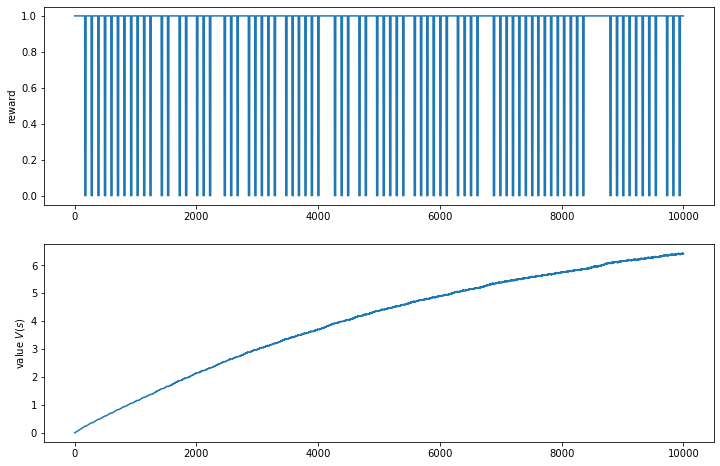

In [142]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(r['env'][:, -1], label='reward')
plt.ylabel('reward')
plt.subplot(2, 1, 2)
plt.plot(r['v'], label='value')
plt.ylabel('value $V(s)$')
plt.show()

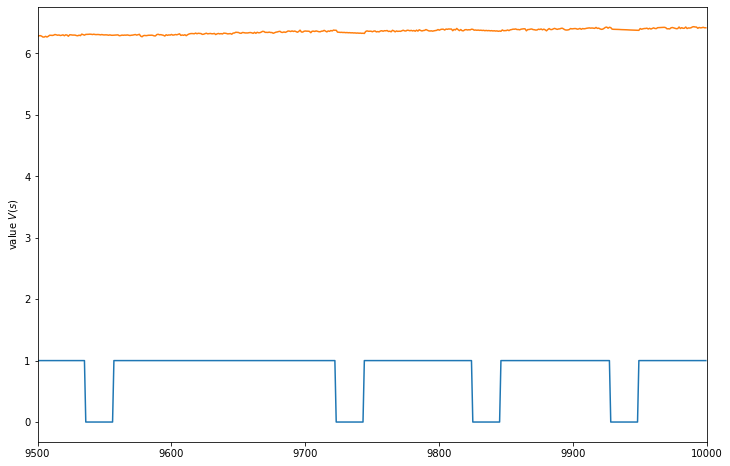

In [139]:
plt.figure(figsize=(12,8))
plt.plot(r['env'][:, -1], label='reward')
plt.ylabel('reward')
plt.plot(r['v'], label='value')
plt.ylabel('value $V(s)$')
plt.xlim(9500, 10000)
plt.show()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 432x288 with 0 Axes>

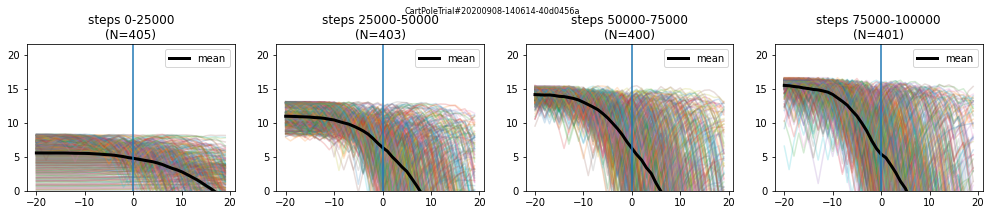

In [36]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=1000, plt=True, learning_rate=3e-5)

In [42]:
r = CartPoleTrial().run(data_dir=None, verbose=False, T=100, plt=True, use_ssp=True)

AttributeError: 'SemanticPointer' object has no attribute 'nondegenerate'

<Figure size 432x288 with 0 Axes>